# **ML Modeling and Evaluation - Classification B**

## Objectives

* Analyse feature importance in calssification model defined in part A of this notebook
* Refit the model with best features only
* Evalueat the model
  
## Inputs

The current version is version="v1"
* Preprocessed and transformed train and test sets:
  * outputs/ml_pipeline/{version}/X_train
  * outputs/ml_pipeline/{version}/y_train
  * outputs/ml_pipeline/{version}/X_test
  * outputs/ml_pipeline/{version}/y_test
* Feature engineering and modeling pipeline:
  * outputs/ml_pipeline{version}/all_features/clf_pipeline_feat_eng.pkl
  * outputs/ml_pipeline{version}/all_features/clf_pipeline_model.pkl

## Outputs

After refitting with best features only:

* Train set (features and target)
* Test set (features and target)
* Feature engineering pipeline
* Modeling pipeline
* Feature importance plot
* Confusion matrix plot

---

# Import Packages for Modelling and Evaluation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# to save pipeline to outputs
import joblib

# scaling
from sklearn.preprocessing import StandardScaler

# ML algorithm
from sklearn.ensemble import RandomForestClassifier

# grid search
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, recall_score

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Step 1: Load Data and Pipelines

In [4]:
df = pd.read_csv('outputs/datasets/cleaned/maternal-health-risk-dataset-clean.csv')
print(df.shape)
df.head()

(1011, 7)


,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


In [5]:
version = "v1"
X_train = pd.read_csv(f'outputs/ml_pipeline/{version}/all_features/X_train.csv')
y_train = pd.read_csv(f'outputs/ml_pipeline/{version}/all_features/y_train.csv')
X_test = pd.read_csv(f'outputs/ml_pipeline/{version}/all_features/X_test.csv')
y_test = pd.read_csv(f'outputs/ml_pipeline/{version}/all_features/y_test.csv')

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(930, 5) (930, 1) (203, 5) (203, 1)


In [6]:
clf_pipeline_feat_eng = joblib.load(filename=f'outputs/ml_pipeline/{version}/all_features/clf_pipeline_feat_eng.pkl')
clf_pipeline_feat_eng

Pipeline(steps=[('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BloodSugar', 'SystolicBP'])),
                ('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

In [7]:
pipeline_clf = joblib.load(filename=f'outputs/ml_pipeline/{version}/all_features/clf_pipeline_model.pkl')
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=140,
                                        random_state=0))])

---

## Assess Feature Importance of Classifier Pipeline

Recall the features in the dataset:

In [8]:
X_train.head()

,Age,SystolicBP,BloodSugar,BodyTemp,HeartRate
0,2.562881,3667.547753,0.556858,37.8,70
1,2.850816,3667.547753,0.563778,38.3,76
2,2.485992,2621.220233,0.555252,36.7,76
3,3.182922,4871.954434,0.565231,36.7,90
4,2.802700,3667.547753,0.556311,36.7,70


Get best features and their importance in descending order:

* The 3 most important features in descending order are ['BloodSugar', 'SystolicBP', 'Age'].The model was trained on them.


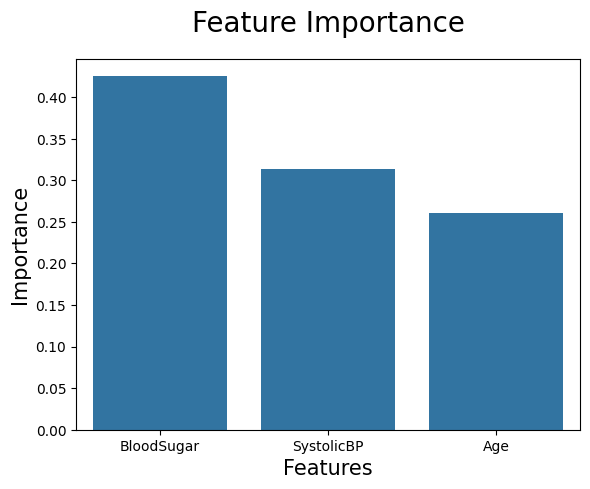

In [9]:
# Code inspiration from Code Institute Churnometer walkthrough project
# adapted for this project

# create DataFrame to display feature importance
df_feature_importance = (
                        pd.DataFrame(
                            data={
                                'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],  # noqa
                                'Importance': pipeline_clf['model'].feature_importances_  # noqa
                            }
                        ).sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(
    f"* The {len(best_features)} most important features in "
    f"descending order are {df_feature_importance['Feature'].to_list()}."
    "The model was trained on them."
    )

fig = plt.figure(figsize=(6,5))
ax = sns.barplot(df_feature_importance, x='Feature', y='Importance')
ax.set_title("Feature Importance", fontsize=20, y=1.05)
ax.set_xlabel("Features",fontsize=15)
ax.set_ylabel("Importance",fontsize=15)

plt.tight_layout()
plt.show()

Note that these features also agree with the results from our correlation study. Additionaly, DiastolicBP is dropped which is the same result as we got from the SmartCorrelatedSelection in the previous notebook.

## Step 3: Refit Pipeline with best features

Note that in our project we include a step for sample rebalancing with SMOTE, this could be sensitive to the dropping of features. Hence, the result from the model using only the most important features could differ somewhat from the results from the one fitted with all features and using features selection in the pipeline. This difference should however not be too big, and the improved efficiency should be worth it. We will check whether we confirm this assumption in the Conclusions of this notebook.

### Rewrite ML pipeline for feature engineering

In [10]:
best_features

['BloodSugar', 'SystolicBP', 'Age']

In [11]:
def PipelineFeatureEngineering():
    """
    Defines a pipeline including the feature engineering steps from before 
    but dropping the SmartCorrelatedSelection
    Winsorizer
    Box-Cox transformation
    """
    pipeline_base = Pipeline([
        ("Winsorizer", Winsorizer(
                            capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=["BloodSugar", "SystolicBP"]
                            )),
        ("BoxCoxTransformation", vt.BoxCoxTransformer(variables=[
                                                    "Age",
                                                    "SystolicBP",
                                                    "BloodSugar"
                                                    ])),
    ])

    return pipeline_base


PipelineFeatureEngineering()

Pipeline(steps=[('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BloodSugar', 'SystolicBP'])),
                ('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar']))])

### Rewrite ML Pipeline for Modelling

In [12]:
# Pipeline Optmization: Model
def PipelineClassifier(model):
    """
    Defines the model pipeline with feature scaling and model
    no feature selection necessary
    best features are known
    """
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

### Split Train and Test set again

Consider only most important features: `["BloodSugar", "SystolicBP", "Age"]`

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['RiskLevel'], axis=1),
    df['RiskLevel'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 6) (808,) (203, 6) (203,)


Filter the most important features:

In [14]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(808, 3) (808,) (203, 3) (203,)


,BloodSugar,SystolicBP,Age
728,7.01,120,20
658,9.00,120,30
150,6.70,100,18


### Fit Feature Engineering Pipeline

In [15]:
# Create feature engineering pipeline
pipeline_feat_eng = PipelineFeatureEngineering()

# fit on the train set and transform train set
X_train = pipeline_feat_eng.fit_transform(X_train)
# transform the test set
X_test = pipeline_feat_eng.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 3) (808,) (203, 3) (203,)


### **Handle Target Imbalance**

Same as in the previous notebook but considering only most important features!

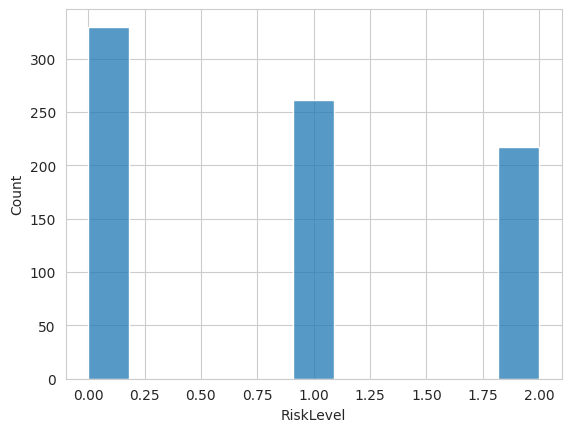

In [16]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

In [17]:
y_train.value_counts()

RiskLevel
0    330
1    261
2    217
Name: count, dtype: int64

**Resample the dataset with SMOTE**

Do moderate resampling again.

In [18]:
# Create SMOTE object

oversample = SMOTE(
                sampling_strategy={
                1: 300,
                2: 300
                }, 
                random_state=0
                )

# fit oversample to train set and resample the train set
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(930, 3) (930,) (203, 3) (203,)


Check the target distibution for the train set again after resampling. It is now more balanced but purposefully not completely balanced.

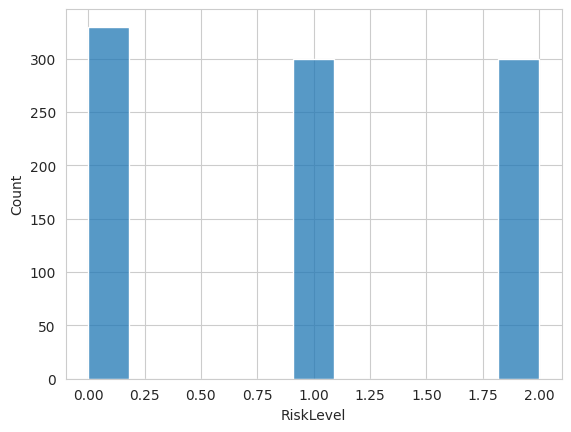

In [19]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

### Grid Search CV

Use the best model and best parameters from the search in the previous notebook.

* RandomForestClassification with hyperparameters:
  * 'model__max_depth': 10
  * 'model__max_leaf_nodes': None
  * 'model__min_samples_leaf': 1
  * 'model__min_samples_split': 2
  * 'model__n_estimators': 140

In [20]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0)
}

params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [140],
        'model__max_depth': [10],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [None]
    }
}

We use the same custom function as in the previous notebook:

In [21]:
# The code for this class was taken from the Code Institute churnometer walkthrough project

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClassifier(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


In [22]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, average="macro"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [23]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.794444,0.813434,0.828788,0.012795,10,None,1,2,140


Define the best Classifier Pipeline

In [24]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=140,
                                        random_state=0))])

### Assess feature importance again

* The 3 most important features in descending order are ['BloodSugar', 'SystolicBP', 'Age'].The model was trained on them.


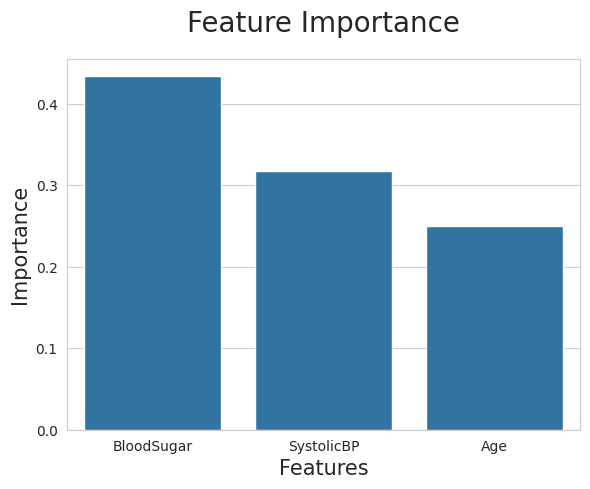

In [26]:

# Code inspiration from Code Institute Churnometer walkthrough project
# adapted for this project

#best features are already known
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (
                        pd.DataFrame(
                            data={
                                'Feature': best_features,
                                'Importance': pipeline_clf['model'].feature_importances_  # noqa
                            }
                        ).sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(
    f"* The {len(best_features)} most important features in "
    f"descending order are {df_feature_importance['Feature'].to_list()}."
    "The model was trained on them."
    )

fig_feat_imp = plt.figure(figsize=(6,5))
ax = sns.barplot(df_feature_importance, x='Feature', y='Importance')
ax.set_title("Feature Importance", fontsize=20, y=1.05)
ax.set_xlabel("Features",fontsize=15)
ax.set_ylabel("Importance",fontsize=15)

plt.tight_layout()
plt.show()

### Evaluate Optimized Pipeline on Train and Test Sets

To get a quick evaluation summary we use the same custom function as in the previous notebook:

In [27]:
# Code inspiration for these functions was taken from the Code Institute
# Churnometer walkthrough project

def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              290              26                9
Prediction mid risk               37             261               10
Prediction high risk               3              13              281


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.89      0.88      0.89       330
    mid risk       0.85      0.87      0.86       300
   high risk       0.95      0.94      0.94       300

    accuracy                           0.89       930
   macro avg       0.90      0.90      0.90       930
weighted avg       0.90      0.89      0.89       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               61              12                2
Prediction mid risk               11              61               

Show in dataframe:

In [28]:
label_map = ['low risk', 'mid risk', 'high risk']
prediction_train = pipeline_clf.predict(X_train)
report_train = pd.DataFrame(classification_report(y_train, prediction_train, target_names=label_map,output_dict=True)).T

confusion_matrix_train = pd.DataFrame(confusion_matrix(y_true=prediction_train, y_pred=y_train),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])

prediction_test = pipeline_clf.predict(X_test)
report_test = pd.DataFrame(classification_report(y_test, prediction_test, target_names=label_map,output_dict=True)).T

confusion_matrix_test = pd.DataFrame(confusion_matrix(y_true=prediction_test, y_pred=y_test),
                            columns=[["Actual " + sub for sub in label_map]],
                            index=[["Prediction " + sub for sub in label_map]])

In [29]:
report_train

,precision,recall,f1-score,support
low risk,0.892308,0.878788,0.885496,330.000000
mid risk,0.847403,0.870000,0.858553,300.000000
high risk,0.946128,0.936667,0.941374,300.000000
accuracy,0.894624,0.894624,0.894624,0.894624
macro avg,0.895279,0.895152,0.895141,930.000000
weighted avg,0.895184,0.894624,0.894830,930.000000


In [30]:
report_test

,precision,recall,f1-score,support
low risk,0.813333,0.835616,0.824324,73.000000
mid risk,0.792208,0.813333,0.802632,75.000000
high risk,0.941176,0.872727,0.905660,55.000000
accuracy,0.837438,0.837438,0.837438,0.837438
macro avg,0.848906,0.840559,0.844205,203.000000
weighted avg,0.840166,0.837438,0.838347,203.000000


In [31]:
confusion_matrix_train

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,290,26,9
Prediction mid risk,37,261,10
Prediction high risk,3,13,281


In [32]:
confusion_matrix_test

,Actual low risk,Actual mid risk,Actual high risk
Prediction low risk,61,12,2
Prediction mid risk,11,61,5
Prediction high risk,1,2,48


Comparison:

* model with all features:
  * high-risk recall train: 94%
  * high-risk recall test: 89%
  * high-risk recall gap: 5 percentage points
  * low-risk-precision train: 89%
  * low-risk-precision test: 79%
  * low-risk-precision gap: 10 percentage
* model with only best features:
  * high-risk recall train: 94%
  * high-risk recall test: 87%
  * high-risk recall gap: 7 percentage points
  * low-risk-precision train: 89%
  * low-risk-precision test: 81%
  * low-risk-precision gap: 8 percentage points

When compared to the model fitted with all features (see previous notebook) the high-risk recall and low-risk precision for test sets stay the same. There is a slight decrease in high-risk recall for the test set and a slight increase in low-risk precision for the test set. Which makes the train-test-gap slightly larger for high-risk recall and slightly smaller for low-risk precision. These changes are relatively small and do not alter the model performance significantly while improving efficiency in model training.

### Visualize Confusion matrix:

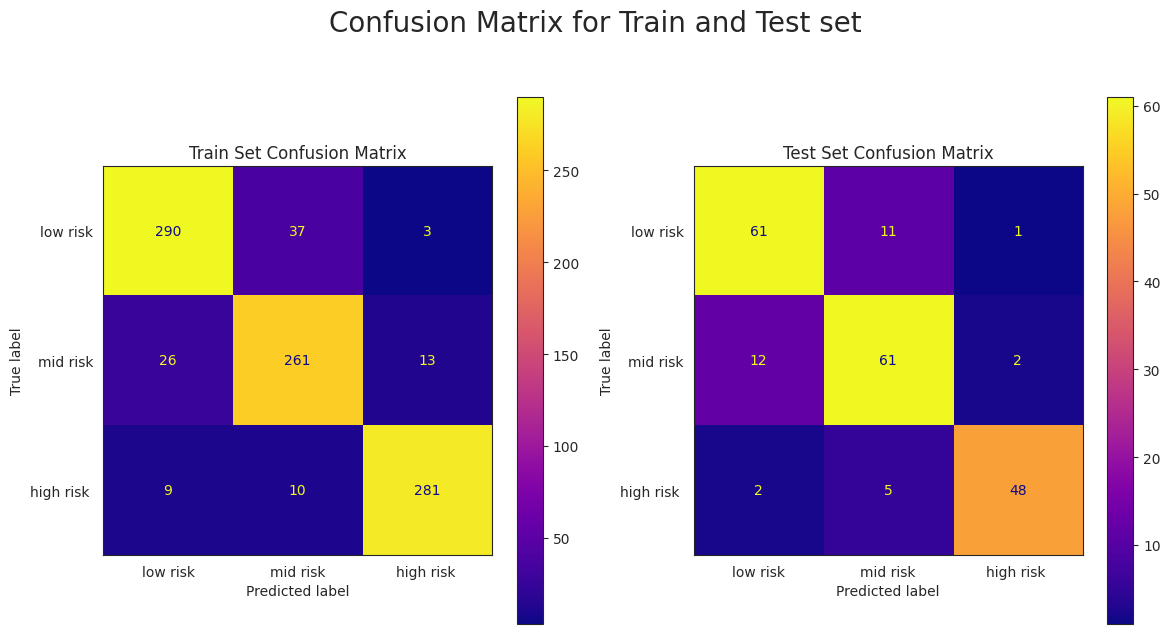

In [33]:
sns.set_style("white")
predictions_train = pipeline_clf.predict(X_train)
predictions_test = pipeline_clf.predict(X_test)
cm_train = confusion_matrix(y_train, predictions_train, labels=pipeline_clf.classes_)
cm_test = confusion_matrix(y_test, predictions_test, labels=pipeline_clf.classes_)


fig_cm, axes = plt.subplots(1, 2, figsize=(12, 6))
fig_cm.suptitle("Confusion Matrix for Train and Test set", fontsize=20, y=1.05)

# Recall subplot

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["low risk", "mid risk", "high risk "])
disp_train.plot(ax=axes[0], values_format='d', cmap="plasma")
axes[0].set_title("Train Set Confusion Matrix")


disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["low risk", "mid risk", "high risk "])
disp_test.plot(ax=axes[1], values_format='d', cmap="plasma")
axes[1].set_title("Test Set Confusion Matrix")

plt.tight_layout()
plt.show()

## Step 4: Push final files to Repo

We generate the following files:

* Train set
* Test set
* Features Engineering Pipeline
* Modeling Pipeline
* Feature importance plot
* Confusion matrix plot

In [36]:
version = 'v1'
file_path = f'outputs/ml_pipeline/{version}/best_features'

In [ ]:
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

# save plots for documentation
try:
    os.makedirs("documentation/plots")
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/v1/best_features'


### Train Set

The data is transformed already with the feature engineering pipeline and SMOTE applied.

In [53]:
print(X_train.shape)
X_train.head()

(930, 3)


,BloodSugar,SystolicBP,Age
0,0.556858,3667.547753,2.562881
1,0.563778,3667.547753,2.850816
2,0.555252,2621.220233,2.485992
3,0.565231,4871.954434,3.182922
4,0.556311,3667.547753,2.802700


In [49]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [50]:
y_train.head()

0    1
1    1
2    0
3    2
4    0
Name: RiskLevel, dtype: int64

In [51]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

The data is transformed already with the feature engineering pipeline and SMOTE applied.

In [54]:
print(X_test.shape)
X_test.head()

(203, 3)


,BloodSugar,SystolicBP,Age
801,0.556809,3667.547753,2.525557
311,0.556311,2158.748161,2.957047
85,0.556311,2158.748161,2.485992
435,0.565231,4871.954434,2.957047
204,0.559034,1580.923565,2.350874


In [53]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [54]:
y_test.head()

801    1
311    0
85     1
435    2
204    0
Name: RiskLevel, dtype: int64

In [55]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### ML Pipeline: Feature Engineering Pipeline

The pipeline that is responsible for winsorizing and Box-Cox tranforming.

For new data this pipeline should be used in conjunction with the modeling pipeline when used on real data.

For train and test set we only use the model pipeline because the data is already preprocessed.

In [55]:
pipeline_feat_eng

Pipeline(steps=[('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['BloodSugar', 'SystolicBP'])),
                ('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar']))])

In [57]:
joblib.dump(value=pipeline_feat_eng,  filename=f"{file_path}/clf_pipeline_feat_eng.pkl")

['outputs/ml_pipeline/v1/best_features/clf_pipeline_feat_eng.pkl']

### ML Pipeline: Model Pipeline

The pipeline that is responsible for scaling, feature selection and model. Note that we will continue looking at the features selected in the next notebook.

In [56]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=140,
                                        random_state=0))])

In [59]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/v1/best_features/clf_pipeline_model.pkl']

### Feature Importance Plot

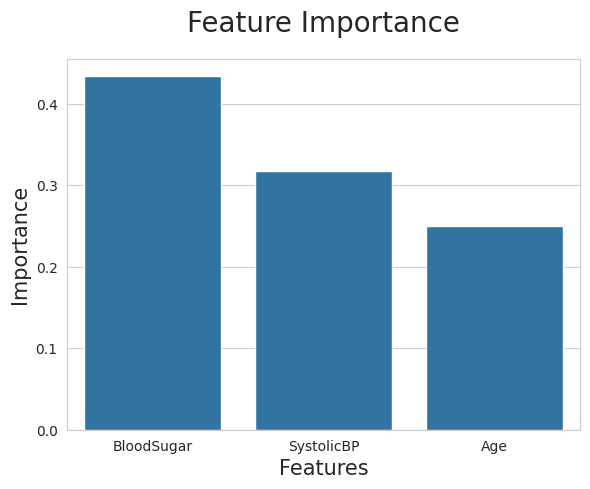

In [34]:
fig_feat_imp

In [37]:
fig_feat_imp.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')
fig_feat_imp.savefig(f'documentation/plots/feature_importance.png', bbox_inches='tight')

### Confusion Matrix Plot

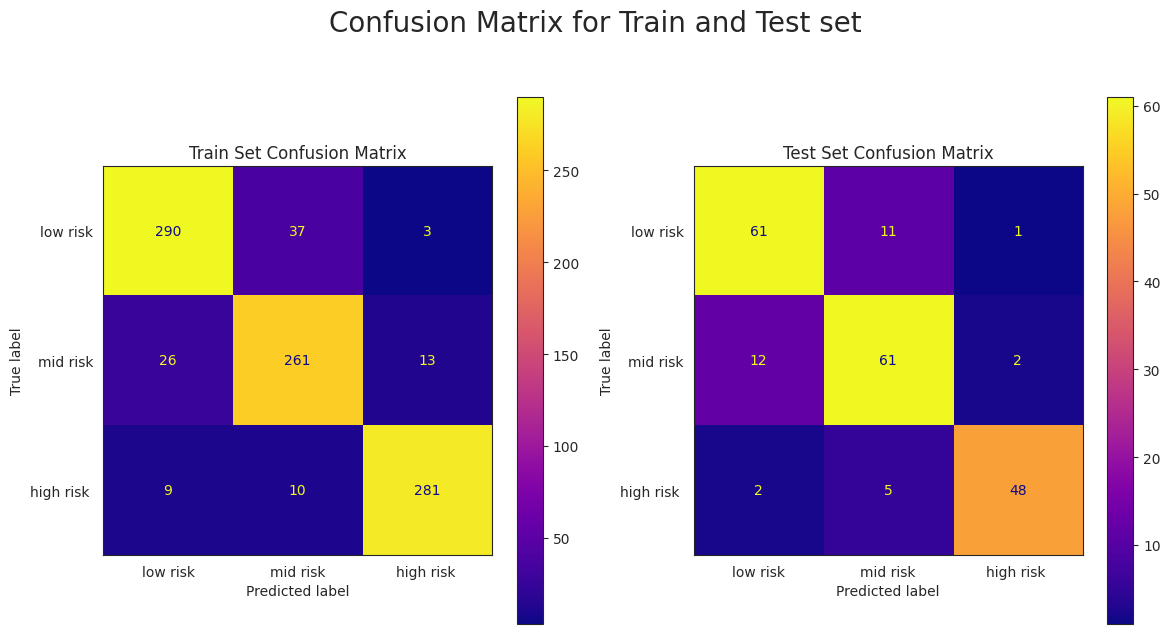

In [38]:
fig_cm

In [39]:
fig_cm.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight')
fig_cm.savefig(f'documentation/plots/confusion_matrix_best_features.png', bbox_inches='tight')

# Conclusions

In this notebook we:

* Assessed the feauture importance of the best model found in the previous notebook
* Split test and train set considering only best features
* Refit the feature engineering pipeline
* Refit the model pipeline
* Evalueated the optimised pipeline
* Saved pipelines, train and test set as well as feature importance and confusion matrix plots to outputs

This concludes out study of the maternal health risk dataset.